In [1]:
import warnings
warnings.simplefilter(action='ignore',)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Function
from torchvision import datasets, transforms
from tqdm.auto import tqdm

import qiskit
from qiskit import Aer, QuantumCircuit, transpile, assemble
backend = Aer.get_backend("statevector_simulator")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
n_samples = 512

X_train = datasets.MNIST(root='../../data/', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

X_train.data = X_train.data[:n_samples]
X_train.targets = X_train.targets[:n_samples]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=8, shuffle=True)

In [3]:
n_samples = 128

X_test = datasets.MNIST(root='../../data/', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

X_test.data = X_test.data[:n_samples]
X_test.targets = X_test.targets[:n_samples]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [4]:
class QNN_circuit:
    
    def __init__(self, n_qubits, backend, shots):
        self._circuit = QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('θ')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit, self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        probabilities = counts / self.shots
        expectation = np.sum(states * probabilities)   
        return np.array([expectation])

Expected value for rotation pi 610.1328125


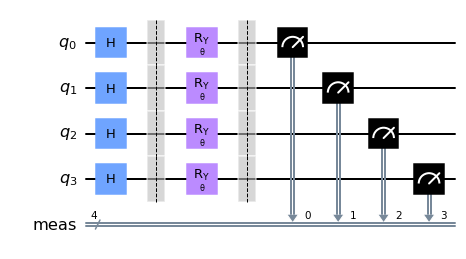

In [5]:
circuit = QNN_circuit(4, backend, 128)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw(output="mpl")

In [6]:
class HybridFunction(Function):

    def forward(ctx, inputs, quantum_circuit, shift):
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = []
        for input in inputs:
            expectation_z.append(ctx.quantum_circuit.run(input.tolist()))
        result = torch.tensor(expectation_z).to(device)
        
        ctx.save_for_backward(inputs, result)
        return result

    def backward(ctx, grad_output):
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]).cuda() - torch.tensor([expectation_left]).to(device)
            gradients.append(gradient)
        
        # gradients = np.array([gradients]).T
        gradients = torch.tensor([gradients]).to(device)
        gradients = torch.transpose(gradients, 0, 1)

        # return torch.tensor([gradients]).float() * grad_output.float(), None, None
        return gradients.float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QNN_circuit(4, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [7]:
class QNN(nn.Module):
    def __init__(self):
        super(QNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)
        self.hybrid = [Hybrid(backend, 100, np.pi / 2) for i in range(10)]

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        
#         x = x.view(1, -1)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.fc3(x)
#         x = self.hybrid(x)
        x = torch.chunk(x, 10, dim=1)
        x = tuple([hy(x_) for hy, x_ in zip(self.hybrid, x)])
        return torch.cat(x, -1)

In [8]:
model = QNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
cost_func = torch.nn.CrossEntropyLoss()
print(model)

QNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [9]:
NUM_EPOCHS = 20
loss_list, acc_list = [], []

def calculate_acc(output,acc):
    predict = output.argmax(dim=1, keepdim=True) 
    acc += predict.eq(target.view_as(predict)).sum().item()
    return acc

model.train()
for epoch in range(NUM_EPOCHS):
    acc,total_loss = 0,[]
    for data, target in tqdm(train_loader, desc="Epoch[{:2d}/{}]".format(epoch+1,NUM_EPOCHS)):
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data).to(device)
        acc = calculate_acc(output,acc)
        loss = cost_func(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    acc_list.append(acc/32)
    print('train_acc: {:5.2f} | train_loss: {:.4f}'.format(acc/len(train_loader)*100/8,loss_list[-1]))


train_acc: 12.50 | train_loss: 78.0016



train_acc: 33.79 | train_loss: 51.5259



train_acc: 58.79 | train_loss: 28.4776



train_acc: 65.82 | train_loss: 25.6578



train_acc: 72.85 | train_loss: 17.2813



train_acc: 76.95 | train_loss: 14.0701



train_acc: 80.86 | train_loss: 13.8532



train_acc: 81.05 | train_loss: 13.2975



train_acc: 85.74 | train_loss: 10.6937



train_acc: 85.94 | train_loss: 9.6498



train_acc: 86.13 | train_loss: 9.2748



train_acc: 86.72 | train_loss: 9.2073



train_acc: 88.09 | train_loss: 7.1449



train_acc: 87.70 | train_loss: 8.2700



train_acc: 91.02 | train_loss: 6.3092



train_acc: 90.04 | train_loss: 5.3490



train_acc: 91.99 | train_loss: 5.3869



train_acc: 91.99 | train_loss: 5.3799



train_acc: 90.04 | train_loss: 5.2915



train_acc: 91.60 | train_loss: 5.6823


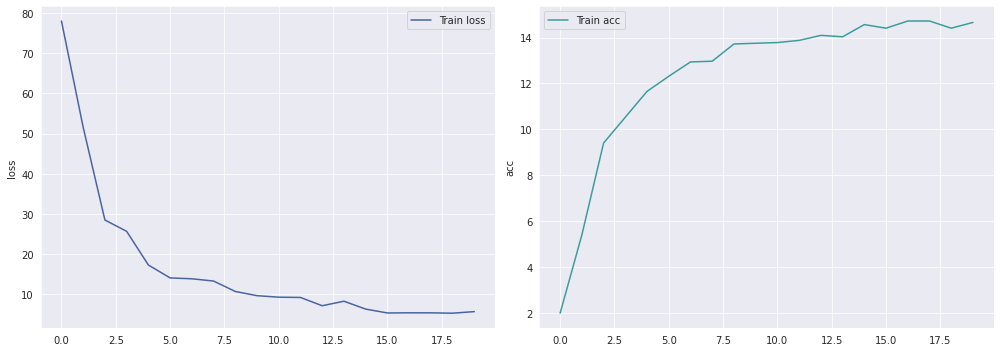

In [10]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 2, figsize=(14,5))

ax[0].plot(loss_list, label="Train loss", color="#4863A0")
ax[0].set_ylabel('loss')
ax[0].legend(loc="upper right")

ax[1].plot(acc_list, label="Train acc", color="#3B9C9C")
ax[1].set_ylabel('acc')
ax[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

In [11]:
model.eval()

def calculate_acc(output,acc):
    predict = output.argmax(dim=1, keepdim=True) 
    acc += predict.eq(target.view_as(predict)).sum().item()
    return acc
    
with torch.no_grad():
    
    acc,total_loss = 0,[]
    for data, target in tqdm(test_loader):
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data).to(device)     
        acc = calculate_acc(output,acc)
        
        loss = cost_func(output, target)
        total_loss.append(loss.item())     
    print('Performance on test data:\n  Loss: {:.4f}\n  Accuracy: {:.1f}%'.format(
        sum(total_loss)/len(total_loss),acc/len(test_loader)*100))


Performance on test data:
  Loss: 6.9242
  Accuracy: 92.2%
